load scientific libraries

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
from math import pi
from math import exp
import matplotlib.pyplot as plt
import seaborn as sns

load Iris dataset

In [4]:
df = pd.read_csv("/Users/User/Desktop/Iris_dataset.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


load wheat seeds dataset

In [5]:
df1 = pd.read_csv("/Users/User/Desktop/Seeds1_dataset.csv", encoding='latin1')
df1.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,types_of_wheat_seeds
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


convert categorical class labels of Iris to numeric class labels

In [6]:
data=df.replace(to_replace=['setosa', 'versicolor', 'virginica'], value=[0, 1, 2])
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


choose prototypes randomly

In [30]:
prototypes = data.sample(n=8,replace=False) # for iris dataset
#prototypes = df1.sample(n=8,replace=False) # for seeds dataset
prototypes

,sepal_length,sepal_width,petal_length,petal_width,species
3,4.6,3.1,1.5,0.2,0
146,6.3,2.5,5.0,1.9,2
130,7.4,2.8,6.1,1.9,2
41,4.5,2.3,1.3,0.3,0
10,5.4,3.7,1.5,0.2,0
30,4.8,3.1,1.6,0.2,0
54,6.5,2.8,4.6,1.5,1
63,6.1,2.9,4.7,1.4,1


In [31]:
new_data = data.loc[set(data.index).symmetric_difference(set(prototypes.index))].dropna() # for iris
#new_data = df1.loc[set(df1.index).symmetric_difference(set(prototypes.index))].dropna() # for seeds
new_data.shape

(142, 5)

split data for training the model (train data)

In [32]:
train_data = new_data.sample(frac = 0.6)
train_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
119,6.0,2.2,5.0,1.5,2
76,6.8,2.8,4.8,1.4,1
44,5.1,3.8,1.9,0.4,0
13,4.3,3.0,1.1,0.1,0
1,4.9,3.0,1.4,0.2,0


test data

In [33]:
test_data = new_data.loc[set(new_data.index).symmetric_difference(set(train_data.index))].dropna()
test_data.shape

(57, 5)

calculate the standard deviation and variance of the train data

In [34]:
std = train_data.std()
std.shape
var = train_data.var()
np.array(var)

array([0.69318768, 0.18485434, 3.3322605 , 0.58438375, 0.66722689])

define pdf of gaussian distribution

In [12]:
def gaussian(train_data,prototypes,std):
    d = (train_data[0:4] - prototypes[0:4])**2
    pdf = np.prod((1/((std[0:4])*np.sqrt(np.pi*2)))*(np.exp(-d/(2*(std[0:4])))))
    return pdf

define pdf of logistic distribution

In [14]:
def logistic(train_data,prototypes,std):
    d = (train_data[0:4] - prototypes[0:4])**2
    numerator = np.exp(-d/(std[0:4]))
    denominator = std[0:4] * (1+numerator)**2
    pdf = np.prod(numerator/denominator)
    return pdf

define pdf of lognormal pdf

In [15]:
def lognormal(train_data,prototypes,std):
    d = (np.log(train_data[0:4]) - prototypes[0:4])**2
    pdf = np.prod((1/(train_data[0:4]*(std[0:4])*np.sqrt(np.pi*2)))*(np.exp(-d/(2*(std[0:4])**2))))
    return pdf

posterior probability of x assigned to prototype w_j w.r.t correct classes

In [16]:
def postprobprotocc(x, prototypes,var):
    p_cc = []
    #n_prototypes = 1/prototypes.shape[0]
    n_prototypes = 1/6
    for id2, w in enumerate(np.array(prototypes)):
        if w[-1] == x[-1]:
            #pdf1 = gaussian(x,w,np.array(var)) * n_prototypes
            pdf1 = logistic(x,w,np.array(var)) * n_prototypes
            #pdf1 = lognormal(x,w,np.array(var)) * n_prototypes
            p_cc.append(pdf1)
    return sum(p_cc)

posterior probability of x assigned to prototype w_j w.r.t all classes

In [18]:
def postprobprotoac(x, prototypes,var):
    p_ac = []
    #n_prototypes = 1/prototypes.shape[0]
    n_prototypes = 1/6
    for id2, w in enumerate(np.array(prototypes)):
            #pdf2 = gaussian(x,w,np.array(var)) * n_prototypes
            pdf2 = logistic(x,w,np.array(var)) * n_prototypes
            #pdf2 = lognormal(x,w,np.array(var)) * n_prototypes
            p_ac.append(pdf2)
    return sum(p_ac)

define update rule for prototypes

In [46]:
def updaterule(train_data, prototypes, var, alpha):
    epochs = 10
    #alpha = 0.3
    s=1
    #n_prototypes = 1/prototypes.shape[0]
    n_prototypes = 1/6
    #for id1, epo in enumerate(range(epochs)):
        #alpha = lrate * (1.0-(epo/epochs))
    for id2, x in enumerate(np.array(train_data)):
        max_log_ratio = []
        new_weight = []
        log_total = []
        wprobcc = postprobprotocc(x, prototypes, var)
        wprobac = postprobprotoac(x, prototypes, var)
        for id3, w in enumerate(np.array(prototypes)):
            #p_y = (gaussian(x,w,var)*n_prototypes)/wprobcc
            #p = (gaussian(x,w,var)*n_prototypes)/wprobac
            p_y = (logistic(x,w,var)*n_prototypes)/wprobcc
            p = (logistic(x,w,var)*n_prototypes)/wprobac
            #p_y = (lognormal(x,w,var)*n_prototypes)/wprobcc
            #p = (lognormal(x,w,var)*n_prototypes)/wprobac
                
            if w[-1] == x[-1]:
                #w[0:4] = w[0:4] + alpha * (p_y - p) * (x[0:4] - w[0:4]) #update rule with respect to Gaussian distribution
                w[0:4] = w[0:4] + alpha * ((2 * (1-np.exp(-(x[0:4]-w[0:4])**2/s)))/(s**2 * (1+np.exp(-(x[0:4]-w[0:4])**2/s)**3))) *(p_y - p) * (x[0:4] - w[0:4]) #update rule with respect to logistic distribution
                #w[0:4] = w[0:4] + (alpha/(var[0:4]*2*np.pi**2)) * (p_y - p) * (np.log(x[0:4]) - w[0:4])/x[0:4]**2
                #w[0:4] = w[0:4] + (alpha/(var[0:4]*2*np.pi**2)) * (p_y - p) * (np.log(x[0:4]) - w[0:4])#update rule with respect to log-normal distribution
                new_weight.append(w)
            else:
                w[0:4] = w[0:4] + alpha * 0 #for c(w_j) != c(x_k)
                new_weight.append(w)
        
    return new_weight

In [48]:
new_weights = updaterule(train_data, prototypes, var,alpha=1000)
new_weights

[array([4.61315827, 3.09840123, 1.49840123, 0.19840123, 0.        ]),
 array([6.3, 2.5, 5. , 1.9, 2. ]),
 array([7.4, 2.8, 6.1, 1.9, 2. ]),
 array([4.51137942, 2.47133585, 1.30039243, 0.29677018, 0.        ]),
 array([5.3010322 , 3.53886367, 1.49963093, 0.19963093, 0.        ]),
 array([4.8       , 3.09839996, 1.58683122, 0.19839996, 0.        ]),
 array([6.5, 2.8, 4.6, 1.5, 1. ]),
 array([6.1, 2.9, 4.7, 1.4, 1. ])]

define cost function

In [37]:
def costfunction(train_data,prototypes,var):
    epochs = 10
    lrate = 0.3
    for id1, epo in enumerate(range(epochs)):
        alpha = lrate * (1.0-(epo/epochs))
        log_total = []
        new_weights = updaterule(train_data, prototypes, var, alpha)
        for i1, ro in enumerate(np.array(train_data)):
            n_prototypes = 1/6
            #new_weights = updaterule(train_data, prototypes, var)
            #new_weights = updaterule(ro, prototypes, var)
            p_x_c_w = postprobprotocc(ro, new_weights, var)
            p_x_a_c_w = postprobprotoac(ro, new_weights, var)
            log_ratio = np.log(p_x_c_w/p_x_a_c_w)
            log_total.append(log_ratio)
            cost_res = -sum(log_total)
        print(id1,cost_res)
        plt.plot(id1,cost_res,color="blue",marker="*")
        plt.xlabel("epochs")
        plt.ylabel("result of cost function")
        #print(i1,cost_res)
    #plt.plot(i1,cost_res,'bo')
plt.show()

0 30.35380389838943
1 30.357233362655904
2 30.360664580812596
3 30.36409752867638
4 30.367532182022202
5 30.370968516583794
6 30.37440650805407
7 30.37784613208585
8 30.38128736429242
9 30.384730180248056


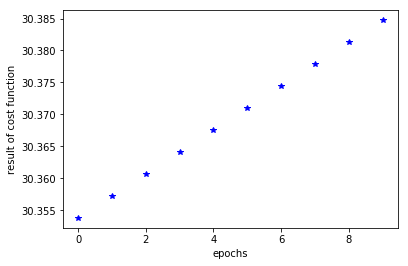

In [38]:
costfunction(train_data,prototypes,var)

define predict function

In [40]:
from sklearn.metrics import confusion_matrix
def predict(train_data, new_weights, var):
    n_prototypes = 1/6
    actual = []
    actual_gra = []
    predicted = []
    predicted_gra = []
    correct = 0
    wrong = 0
    for ix1, row1 in enumerate(np.array(train_data)):
        w_list = []
        
        wprobac = postprobprotoac(row1, new_weights, var)
        wprobcc = postprobprotocc(row1, new_weights, var)
        for ix2, row2 in enumerate(np.array(new_weights)):
            #p_w_j_x = (gaussian(row1, row2, var)*n_prototypes)/wprobac
            p_w_j_x = (logistic(row1, row2, var)*n_prototypes)/wprobac
            #p_w_j_x = (lognormal(row1, row2, var)*n_prototypes)/wprobac
            #p_w_j_x = wprobcc/wprobac
            w_list.append([(p_w_j_x),ix1,row1,row2])
        predict = max(w_list)
        #actual.append([predict[1],predict[2][-1]])
        actual.append(predict[2][-1])
        actual_gra.append([predict[2],predict[3]])
        #a1 = pd.DataFrame(actual_gra)
        
            #print(ix1,row1,ix2,row2,p_w_j_x)
        #print(max(w_list))
        if predict[2][-1] == predict[3][-1]:
            correct +=1
            #predicted.append([predict[1],predict[3][-1]])
            predicted.append(predict[3][-1])
            predicted_gra.append([predict[2],predict[3]])
            
            #plt.plot(prototypes['species'],'+')
            #plt.plot(predict[1][:,-1],'*')
        else:
            wrong += 1
            #predicted.append([predict[1],predict[3][-1]])
            predicted.append(predict[3][-1])
            predicted_gra.append([predict[2],predict[3]])
        #plt.plot(row1[:,-1],'*')
        #plt.plot(prototypes['species'],'*',color='y')
        #plt.plot(predict[0],'+',color='r')
        #plt.plot(predict[0],predict[2][-1])
    #print(actual,predicted)
    ##print(actual_gra,predicted_gra)
    
    print("Accuracy =", (correct/ix1)*100)
    cm = confusion_matrix(actual, predicted)
    #plt.scatter(actual,predicted)
    print(cm)
plt.show()
    

In [49]:
predict(train_data,new_weights,var)

Accuracy = 88.09523809523809
[[33  0  0]
 [ 0 27  1]
 [ 0 10 14]]


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.andrews_curves' is deprecated, import 'pandas.plotting.andrews_curves' instead.
  


Text(0.5,1,'distribution of seeds trian_data with respect to class labels')

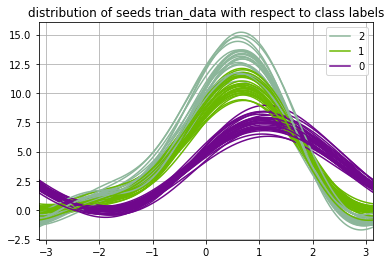

In [42]:
from pandas.tools.plotting import andrews_curves
andrews_curves(train_data, "species")
plt.title('distribution of iris trian_data with respect to class labels')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.andrews_curves' is deprecated, import 'pandas.plotting.andrews_curves' instead.
  """Entry point for launching an IPython kernel.


Text(0.5,1,'distribution of iris test_data with respect to class labels')

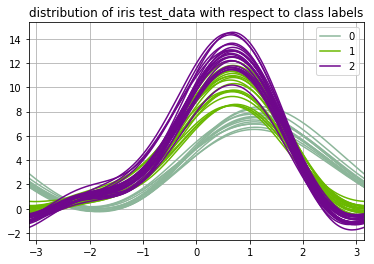

In [43]:
andrews_curves(test_data, "species")
plt.title('distribution of iris test_data with respect to class labels')

In [44]:
pt=np.array(new_weights)
pt

array([[ 4.59923891,  3.09517621,  1.49928565, -1.51719766,  0.        ],
       [ 6.3       ,  2.5       ,  5.        ,  1.9       ,  2.        ],
       [ 7.4       ,  2.8       ,  6.1       ,  1.9       ,  2.        ],
       [ 4.49981935,  2.29928924,  1.2998548 , -0.13834498,  0.        ],
       [ 5.39977794,  3.6985526 ,  1.49983509, -0.19641053,  0.        ],
       [ 4.79918805,  3.09517235,  1.59922363, -1.5185695 ,  0.        ],
       [ 6.5       ,  2.8       ,  4.6       ,  1.5       ,  1.        ],
       [ 6.1       ,  2.9       ,  4.7       ,  1.4       ,  1.        ]])

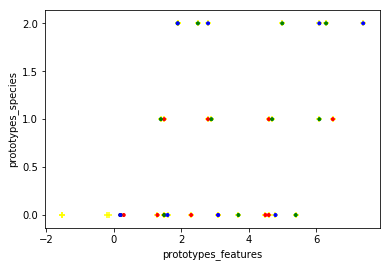

In [45]:
plt.scatter(pt[:,0],pt[:,4],c='yellow',marker="+")
plt.scatter(pt[:,1],pt[:,4],c='yellow',marker="+")
plt.scatter(pt[:,2],pt[:,4],c='yellow',marker="+")
plt.scatter(pt[:,3],pt[:,4],c='yellow',marker="+")

plt.scatter(prototypes['sepal_length'],prototypes['species'],c=['r','g','b'],marker=".")
plt.scatter(prototypes['sepal_width'],prototypes['species'],c=['r','g','b'],marker=".")
plt.scatter(prototypes['petal_length'],prototypes['species'],c=['r','g','b'],marker=".")
plt.scatter(prototypes['petal_width'],prototypes['species'],c=['r','g','b'],marker=".")
plt.xlabel("prototypes_features")
plt.ylabel("prototypes_species")
plt.show()